Notebook currently works only for the data in 'dataset' folder. 

To train & test a model, first change model_name in 'mount drive, initialize variables and import packages', then run sections:
- mount drive, initialize variables and import package
- cxn_model.py
- train & test.py
- save trained model
- metrices.py
possibly: - plot predicted cloud masks

To test a saved model, first check model_name in 'mount drive, initialize variables and import packages', then run sections:
- mount drive, initialize variables and import package
- cxn_model.py
- test model
- metrices.py
possibly: - plot predicted cloud masks

In [13]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm 
from PIL import Image
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

from skimage.io import imread, imshow
from skimage.transform import resize

#pip install rioxarray
#pip install earthpy

import rioxarray as rxr
import xarray as xr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [14]:
dataset = 'dataset' # name of folder 
path_data = '/Users/Willem/Werk/510/caladrius/clouds_Nina/' + dataset + '/'
print(path_data)

model_name = '0113v0_model' # month, day, version, _model
path_model = '/Users/Willem/Werk/510/caladrius/clouds_Nina/saved_models/' + model_name
print(path_model)

/Users/Willem/Werk/510/caladrius/clouds_Nina/dataset/
/Users/Willem/Werk/510/caladrius/clouds_Nina/saved_models/0113v0_model


## Visualization dataset

random indices: [103, 129]
original image 103 of size (512, 512)


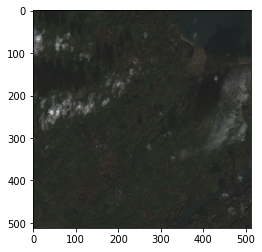

resized image 103 of size (256, 256)


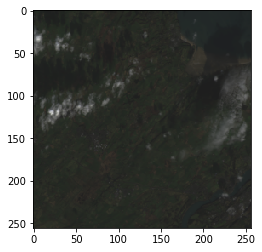

original gt 103 of size (512, 512)


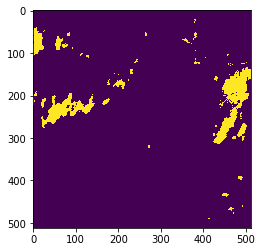

resized gt 103 of size (256, 256)


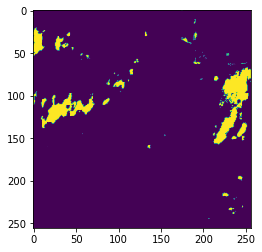

original image 129 of size (512, 512)


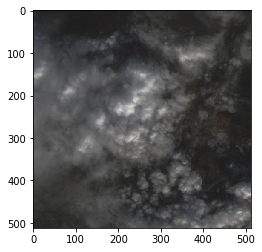

resized image 129 of size (256, 256)


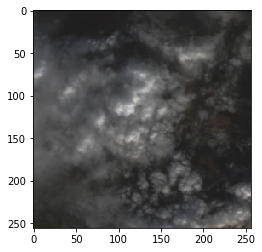

original gt 129 of size (512, 512)


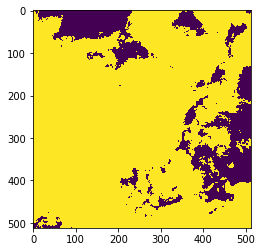

resized gt 129 of size (256, 256)


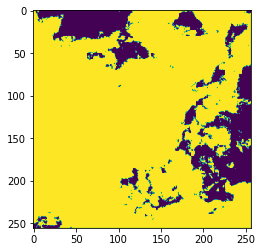

In [15]:
# dataset
# visualize training data, ground truth & rescaling

number_of_visualisations = 2
IMG_HEIGHT = 256
IMG_WIDTH = 256

random_indices = random.sample(range(0,350), number_of_visualisations)
print('random indices: ' + str(random_indices))
 
TRAIN_PATH_R = path_data + 'B4/train/'  #change path 
TRAIN_PATH_G = path_data + 'B3/train/'
TRAIN_PATH_B = path_data + 'B2/train/'

GT_PATH = path_data + 'BQA/train/'
 
for ind in random_indices:
    red    = Image.open(TRAIN_PATH_R + str(ind) + '.png').convert('L')
    green  = Image.open(TRAIN_PATH_G + str(ind) + '.png').convert('L')
    blue   = Image.open(TRAIN_PATH_B + str(ind) + '.png').convert('L')

    rgb = Image.merge("RGB",(red,green,blue))
    print('original image ' + str(ind) + ' of size ' + str(rgb.size))
    plt.imshow(rgb)
    plt.show()
    img_r = np.asarray(rgb) 
    img_r = resize(img_r, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True).astype('uint8')
    img_r_img = Image.fromarray(img_r, 'RGB') # own idea to realize an image plot
    print('resized image ' + str(ind) + ' of size ' + str(img_r_img.size))
    plt.imshow(img_r_img)
    plt.show()      

    gt = Image.open(GT_PATH + str(ind) + '.png')
    print('original gt ' + str(ind) + ' of size ' + str(gt.size))
    plt.imshow(gt)
    plt.show()
    gt_r = np.array(gt)[:,:,1] 
    gt_r = resize(gt_r, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True).astype('uint8')
    gt_r_img = Image.fromarray(gt_r, 'L') # own idea to realize an image plot
    print('resized gt ' + str(ind) + ' of size ' + str(gt_r_img.size))
    plt.imshow(gt_r_img)
    plt.show()




## Visualization dataset_38

In [62]:
# dataset_38
# visualize training data, ground truth & rescaling (38-Cloud)

#number_of_visualisations = 2
IMG_HEIGHT = 384
IMG_WIDTH = 384

#random_indices = random.sample(range(0,10), number_of_visualisations)
#print('random indices: ' + str(random_indices))

TRAIN_FOLDER = path_data + '38-Cloud_training/' 
TRAIN_PATH_R = path_data + '38-Cloud_training/train_red'  #change path 
TRAIN_PATH_G = path_data + '38-Cloud_training/train_green'
TRAIN_PATH_B = path_data + '38-Cloud_training/train_blue'

GT_PATH = path_data + '38-Cloud_training/train_gt'

def get_input_image_names(list_names, directory_name, if_train=True):
    list_img = []
    list_msk = []
    list_test_ids = []

    for filenames in tqdm(list_names['name'], miniters=1000):
        nred = 'red_' + filenames
        nblue = 'blue_' + filenames
        ngreen = 'green_' + filenames

        if if_train:
            dir_type_name = "train"
            fl_img = []
            nmask = 'gt_' + filenames
            fl_msk = directory_name + '/train_gt/' + '{}.TIF'.format(nmask)
            list_msk.append(fl_msk)

        else:
            dir_type_name = "test"
            fl_img = []
            fl_id = '{}.TIF'.format(filenames)
            list_test_ids.append(fl_id)

        fl_img_red = directory_name + '/' + dir_type_name + '_red/' + '{}.TIF'.format(nred)
        fl_img_green = directory_name + '/' + dir_type_name + '_green/' + '{}.TIF'.format(ngreen)
        fl_img_blue = directory_name + '/' + dir_type_name + '_blue/' + '{}.TIF'.format(nblue)
        fl_img.append(fl_img_red)
        fl_img.append(fl_img_green)
        fl_img.append(fl_img_blue)

        list_img.append(fl_img)

    if if_train:
        return list_img, list_msk
    else:
        return list_img, list_test_ids

train_patches_csv_name = 'training_patches_38-Cloud.csv'
df_train_img = pd.read_csv(os.path.join(TRAIN_FOLDER, train_patches_csv_name))
train_img, train_msk = get_input_image_names(df_train_img, TRAIN_FOLDER, if_train=True)

100%|██████████| 100/100 [00:00<00:00, 59033.13it/s]


In [63]:
train_patches_csv_name_ne = 'training_patches_38-cloud_nonempty.csv'
df_train_img_ne = pd.read_csv(os.path.join(TRAIN_FOLDER, train_patches_csv_name_ne))

lst_non_empty = []
for patch in df_train_img['name']:
    lst_non_empty.append(df_train_img_ne['name'].where(df_train_img_ne['name'] == patch).isna().sum())

print(100*5155 - sum(lst_non_empty))

non_empty = [i for i,x in enumerate(lst_non_empty) if x < 5155]

print(non_empty)

for index in non_empty:
    print(df_train_img['name'][index])

5
[72, 73, 94, 95, 96]
patch_5_1_by_5_LC08_L1TP_002053_20160520_20170324_01_T1
patch_5_1_by_5_LC08_L1TP_002054_20160520_20170324_01_T1
patch_6_1_by_6_LC08_L1TP_029040_20160720_20170222_01_T1
patch_6_1_by_6_LC08_L1TP_032029_20160420_20170223_01_T1
patch_6_1_by_6_LC08_L1TP_034034_20160520_20170223_01_T1


/opt/anaconda3/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/opt/anaconda3/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/opt/anaconda3/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


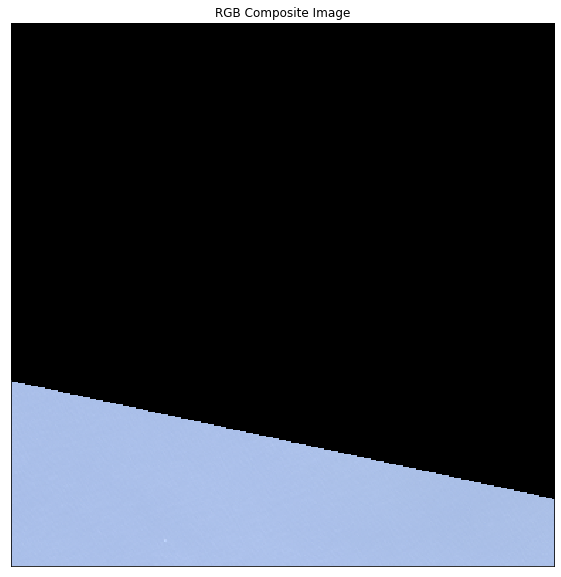

/opt/anaconda3/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/opt/anaconda3/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/opt/anaconda3/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


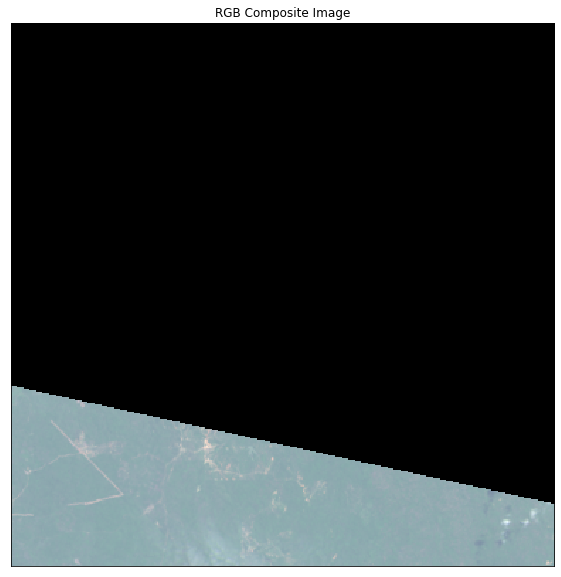

/opt/anaconda3/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/opt/anaconda3/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/opt/anaconda3/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


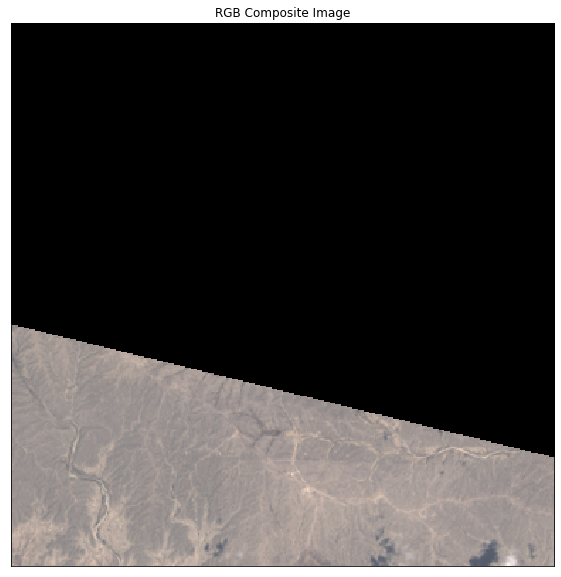

/opt/anaconda3/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/opt/anaconda3/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/opt/anaconda3/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


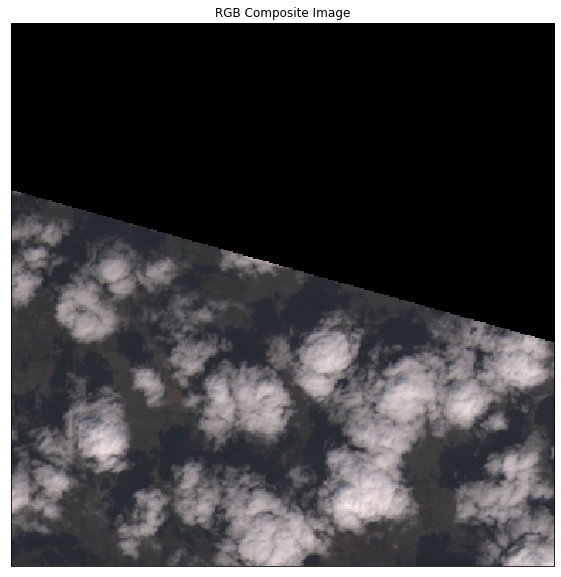

/opt/anaconda3/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/opt/anaconda3/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/opt/anaconda3/lib/python3.7/site-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


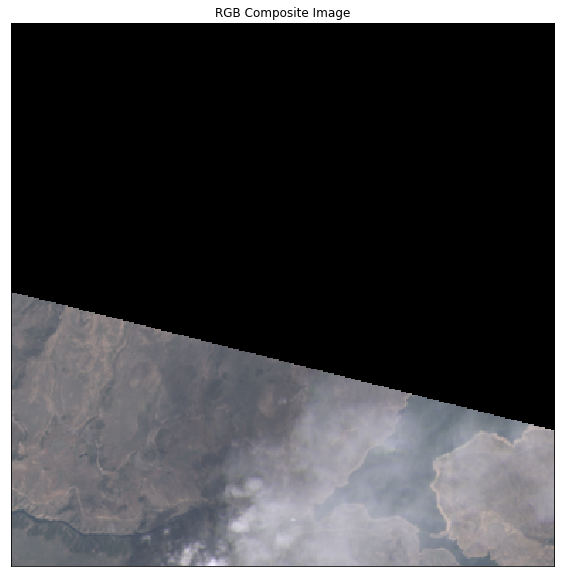

In [64]:
# print('Length train_img ' + str(len(train_img)))

# number_of_visualisations = 3
# random_indices = random.sample(range(0,len(train_img)), number_of_visualisations)
# print('random indices: ' + str(random_indices))
def open_clean_bands(band_path):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.
        
    Returns
    -------
    An single xarray object with the Landsat band data.

    """
     
    return rxr.open_rasterio(band_path, masked=True).squeeze()

for ind in non_empty:
    # band_g = rxr.open_rasterio(train_img[ind][1], masked=True).squeeze()
    # band_g.shape
    # f, ax = plt.subplots()
    # band_g.plot.imshow(ax=ax, cmap='Greys_r')
    # ax.set_axis_off()
    # ax.set_title("Plot of Band Green")
    # Open all bands in a loop
    all_bands = []
    for i, aband in enumerate(train_img[ind]):
        all_bands.append(open_clean_bands(aband))
        # Assign a band number to the new xarray object
        all_bands[i]["band"]=i+1
    train_img_xr = xr.concat(all_bands, dim ='band')
    ep.plot_rgb(train_img_xr.values, rgb = [0, 1, 2], title='RGB Composite Image')
    plt.show()

## Building CXN model

In [44]:
smooth = 0.0000001

def aspp(x,out_shape):
    b0=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(x)
    b0=BatchNormalization()(b0)
    b0=Activation("relu")(b0)

    #b5=DepthwiseConv2D((3,3),dilation_rate=(3,3),padding="same",use_bias=False)(x)
    #b5=BatchNormalization()(b5)
    #b5=Activation("relu")(b5)
    #b5=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b5)
    #b5=BatchNormalization()(b5)
    #b5=Activation("relu")(b5)

    b1=DepthwiseConv2D((3,3),dilation_rate=(6,6),padding="same",use_bias=False)(x)
    b1=BatchNormalization()(b1)
    b1=Activation("relu")(b1)
    b1=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b1)
    b1=BatchNormalization()(b1)
    b1=Activation("relu")(b1)

    b2=DepthwiseConv2D((3,3),dilation_rate=(12,12),padding="same",use_bias=False)(x)
    b2=BatchNormalization()(b2)
    b2=Activation("relu")(b2)
    b2=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b2)
    b2=BatchNormalization()(b2)
    b2=Activation("relu")(b2)	

    b3=DepthwiseConv2D((3,3),dilation_rate=(18,18),padding="same",use_bias=False)(x)
    b3=BatchNormalization()(b3)
    b3=Activation("relu")(b3)
    b3=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b3)
    b3=BatchNormalization()(b3)
    b3=Activation("relu")(b3)

    b4=AveragePooling2D(pool_size=(out_shape,out_shape))(x)
    b4=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b4)
    b4=BatchNormalization()(b4)
    b4=Activation("relu")(b4)
    b4=UpSampling2D((out_shape,out_shape), interpolation='bilinear')(b4)
    x=Concatenate()([b4,b0,b1,b2,b3])
    return x

def jacc_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

def bn_relu(input_tensor):
    """It adds a Batch_normalization layer before a Relu
    """
    input_tensor = BatchNormalization(axis=3)(input_tensor)
    return Activation("relu")(input_tensor)


def contr_arm(input_tensor, filters, kernel_size):
    """It adds a feedforward signal to the output of two following conv layers in contracting path
       TO DO: remove keras.layers.add and replace it with add only
    """

    x = SeparableConv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernel size of (1,1) out of (3,3)

    x1 = SeparableConv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x = tf.keras.layers.add([x, x1])
    x = Activation("relu")(x)
    return x


def imprv_contr_arm(input_tensor, filters, kernel_size ):
    """It adds a feedforward signal to the output of two following conv layers in contracting path
    """

    x = SeparableConv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x0 = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x0 = bn_relu(x0)

    x = SeparableConv2D(filters, kernel_size, padding='same')(x0)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 = SeparableConv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)

    x2 = SeparableConv2D(filters, kernel_size_b, padding='same')(x0)
    x2 = bn_relu(x2)

    x = tf.keras.layers.add([x, x1, x2])
    x = Activation("relu")(x)
    return x


def bridge(input_tensor, filters, kernel_size):
    """It is exactly like the identity_block plus a dropout layer. This block only uses in the valley of the UNet
    """

    x = SeparableConv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x = Dropout(.15)(x)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 =SeparableConv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x = tf.keras.layers.add([x, x1])
    x = Activation("relu")(x)
    return x


def conv_block_exp_path(input_tensor, filters, kernel_size):
    """It Is only the convolution part inside each expanding path's block
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)
    return x


def conv_block_exp_path3(input_tensor, filters, kernel_size):
    """It Is only the convolution part inside each expanding path's block
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)
    return x


def add_block_exp_path(input_tensor1, input_tensor2, input_tensor3):
    """It is for adding two feed forwards to the output of the two following conv layers in expanding path
    """

    x = tf.keras.layers.add([input_tensor1, input_tensor2, input_tensor3])
    x = Activation("relu")(x)
    return x


def improve_ff_block4(input_tensor1, input_tensor2 ,input_tensor3, input_tensor4, pure_ff):
    """It improves the skip connection by using previous layers feature maps
       TO DO: shrink all of ff blocks in one function/class
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
        x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    for ix in range(7):
        if ix == 0:
            x3 = input_tensor3
        x3 = concatenate([x3, input_tensor3], axis=3)
    x3 = MaxPooling2D(pool_size=(8, 8))(x3)

    for ix in range(15):
        if ix == 0:
            x4 = input_tensor4
        x4 = concatenate([x4, input_tensor4], axis=3)
    x4 = MaxPooling2D(pool_size=(16, 16))(x4)

    x = tf.keras.layers.add([x1, x2, x3, x4, pure_ff])
    x = Activation("relu")(x)
    return x


def improve_ff_block3(input_tensor1, input_tensor2, input_tensor3, pure_ff):
    """It improves the skip connection by using previous layers feature maps
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    for ix in range(7):
        if ix == 0:
            x3 = input_tensor3
        x3 = concatenate([x3, input_tensor3], axis=3)
    x3 = MaxPooling2D(pool_size=(8, 8))(x3)

    x = tf.keras.layers.add([x1, x2, x3, pure_ff])
    x = Activation("relu")(x)
    return x


def improve_ff_block2(input_tensor1, input_tensor2, pure_ff):
    """It improves the skip connection by using previous layers feature maps
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    x = tf.keras.layers.add([x1, x2, pure_ff])
    x = Activation("relu")(x)
    return x


def improve_ff_block1(input_tensor1, pure_ff):
    """It improves the skip connection by using previous layers feature maps
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    x = tf.keras.layers.add([x1, pure_ff])
    x = Activation("relu")(x)
    return x


def model_arch(input_rows=256, input_cols=256, num_of_channels=3, num_of_classes=1):
    inputs = Input((input_rows, input_cols, num_of_channels))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)

    conv1 = contr_arm(conv1, 32, (3, 3))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = contr_arm(pool1, 64, (3, 3))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = contr_arm(pool2, 128, (3, 3))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = contr_arm(pool3, 256, (3, 3))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = imprv_contr_arm(pool4, 512, (3, 3))
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = bridge(pool5, 1024, (3, 3))
    
    conv6  = aspp(conv6,input_rows/32)

    convT7 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv6)
    prevup7 = improve_ff_block4(input_tensor1=conv4, input_tensor2=conv3, input_tensor3=conv2, input_tensor4=conv1, pure_ff=conv5)
    up7 = concatenate([convT7, prevup7], axis=3)
    conv7 = conv_block_exp_path3(input_tensor=up7, filters=512, kernel_size=(3, 3))
    conv7 = add_block_exp_path(conv7, conv5, convT7)

    convT8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv7)
    prevup8 = improve_ff_block3(input_tensor1=conv3, input_tensor2=conv2, input_tensor3=conv1, pure_ff=conv4)
    up8 = concatenate([convT8, prevup8], axis=3)
    conv8 = conv_block_exp_path(input_tensor=up8, filters=256, kernel_size=(3, 3))
    conv8 = add_block_exp_path(input_tensor1=conv8, input_tensor2=conv4, input_tensor3=convT8)

    convT9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv8)
    prevup9 = improve_ff_block2(input_tensor1=conv2, input_tensor2=conv1, pure_ff=conv3)
    up9 = concatenate([convT9, prevup9], axis=3)
    conv9 = conv_block_exp_path(input_tensor=up9, filters=128, kernel_size=(3, 3))
    conv9 = add_block_exp_path(input_tensor1=conv9, input_tensor2=conv3, input_tensor3=convT9)

    convT10 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv9)
    prevup10 = improve_ff_block1(input_tensor1=conv1, pure_ff=conv2)
    up10 = concatenate([convT10, prevup10], axis=3)
    conv10 = conv_block_exp_path(input_tensor=up10, filters=64, kernel_size=(3, 3))
    conv10 = add_block_exp_path(input_tensor1=conv10, input_tensor2=conv2, input_tensor3=convT10)

    convT11 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv10)
    up11 = concatenate([convT11, conv1], axis=3)
    conv11 = conv_block_exp_path(input_tensor=up11, filters=32, kernel_size=(3, 3))
    conv11 = add_block_exp_path(input_tensor1=conv11, input_tensor2=conv1, input_tensor3=convT11)

    conv12 = Conv2D(num_of_classes, (1, 1), activation='sigmoid')(conv11)

    return Model(inputs=[inputs], outputs=[conv12])


## Generator

In [9]:
from tensorflow.python.keras.utils.data_utils import Sequence
import cv2

class DataGenerator(Sequence):
    """Generates data for Keras

    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, images, annotations, classes, to_fit=True,
                 batch_size=32, width=256, height=256, n_channels=3, shuffle=True,
                 augmentation=False, dtype=np.float32):
        """Initialization

        Make sure that the provided class indices start at 1, because 0 is used
        for background predictions.

        :param data_dir: root directory of the images.
        :param data: List that contains both polygons and paths to the images
        :param classes: Dict that contains all the classes and their mask-indices
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param width: int indicating the input width of the model
        :param height: int indicating the input height of the model
        :param n_channels: number of image channels
        :param shuffle: True to shuffle label indexes after every epoch
        :param augmentation: True to augment the images, False no augmentation
        :param dtype: data type of the generated batches
        """
        self.images = images
        self.annotations = annotations

        # class variables
        self.n_classes = len(classes)
        self.class_codes = {}
        for c_indx in classes.values():
            code = np.zeros(self.n_classes, dtype=dtype)
            code[c_indx] = 1
            self.class_codes[c_indx] = code

        self.to_fit = to_fit
        self.batch_size = batch_size
        self.width = width
        self.height = height
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augmentation = augmentation

        self.dtype = dtype
        self.on_epoch_end()


    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.images) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        if self.to_fit:
            return self._generate_X_y(indexes)
        else:
            return self._generate_X(indexes)


    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def _generate_X(self, indexes):
        """Generates data containing batch_size images
        :param indexes: list of ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, self.height, self.width, self.n_channels))

        # Generate data
        for i, im_id in enumerate(indexes):
            # Store sample
            X[i,] = self._load_image(self.images[im_id])
#         X = X/255 # preprocess input (only scaling)
        return X

    def _generate_X_y(self, indexes):
        """Generates data containing batch_size masks
        :param indexes: list of ids to load
        :return: batch of images and masks
        """
        X = np.empty((self.batch_size, self.height, self.width, self.n_channels), dtype=np.uint8)
        _y = np.empty((self.batch_size, self.height, self.width, 1), dtype=np.uint8)

        # Generate data
        for i, im_id in enumerate(indexes):
            
            # Store data
            X[i,] = self._load_image(self.images[im_id])
            _y[i,] = self._load_annotation(self.annotations[im_id])

        if self.augmentation:
            X, _y = self._augment_batch(X, _y)

        y = self._one_hot_encode(_y)
#         X = X/255 # preprocess input (only scaling)

        return X, y


    def _augment_batch(self, X, _y):
        """Apply same augmentation on X and _y.
        :param X: images
        :param _y: segmentation masks
        """
        seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Crop((1, 150), keep_size=True),
            iaa.Affine(rotate=(-30, 30),shear=(-12, 12)),
            iaa.GammaContrast((0.9, 1.2)),
            iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-20, 20)),
            # iaa.ElasticTransformation(alpha=2, sigma=1),
            iaa.AdditiveGaussianNoise(scale=(0,0.01*255))
        ])
        return seq(images=X, segmentation_maps=_y)


    def _one_hot_encode(self, _y):
        y = np.empty((self.batch_size, self.height, self.width, self.n_classes), dtype=self.dtype)
        for i, anno in enumerate(_y):
            y[i,] = utils.one_hot_encode(anno.reshape((self.height, self.width)), self.class_codes, dtype=self.dtype)
        return y


    def _load_image(self, TRAIN_PATH_R, TRAIN_PATH_G, TRAIN_PATH_B):
        """Load image
        :param image_path: path to image to load
        :return: loaded image
        """
        
        red    = Image.open(TRAIN_PATH_R + str(int(id_)) + '.png').convert('L')
        green  = Image.open(TRAIN_PATH_G + str(int(id_)) + '.png').convert('L')
        blue   = Image.open(TRAIN_PATH_B + str(int(id_)) + '.png').convert('L')
        
        
        
#         img = utils.read_image(image_path, dtype=np.uint8)
#         img = utils.bgr_to_rgb(img)
        return img

    def _load_annotation(self, anno_path):
        """Load annotation
        :param anno_path: path to annotation to load
        :return: loaded annotation
        """
        anno = utils.read_annotation(anno_path, dtype=np.uint8)
        return anno.reshape((anno.shape[0], anno.shape[1], 1))

    
    

ModuleNotFoundError: No module named 'cv2'

In [11]:
TRAIN_PATH_R = path_data + 'B4/train/'  #change path 
TRAIN_PATH_G = path_data + 'B3/train/'
TRAIN_PATH_B = path_data + 'B2/train/'
 

red    = Image.open(TRAIN_PATH_R + str(int(id_)) + '.png').convert('L')
green  = Image.open(TRAIN_PATH_G + str(int(id_)) + '.png').convert('L')
blue   = Image.open(TRAIN_PATH_B + str(int(id_)) + '.png').convert('L')

rgb = Image.merge("RGB",(red,green,blue))
img_b = np.asarray(rgb) 

#img_r = imread(TRAIN_PATH_R + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
#img_g = imread(TRAIN_PATH_G + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
#img_b = imread(TRAIN_PATH_B + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]

#img_r = resize(img_r, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
#img_g = resize(img_g, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
#img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)

img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
img_b= (img_b/255.0)

In [40]:
TRAIN_PATH_R = path_data + 'B4/train/'  #change path 
TRAIN_PATH_G = path_data + 'B3/train/'
TRAIN_PATH_B = path_data + 'B2/train/'

id_ = 7
 
red    = Image.open(TRAIN_PATH_R + str(int(id_)) + '.png').convert('L')
green  = Image.open(TRAIN_PATH_G + str(int(id_)) + '.png').convert('L')
blue   = Image.open(TRAIN_PATH_B + str(int(id_)) + '.png').convert('L')

rgb = Image.merge("RGB",(red,green,blue))

In [61]:
np.asarray(Image.open(TRAIN_PATH_R + str(int(id_)) + '.png').convert('RGB'))

array([[[ 69,   5,  88],
        [ 68,   3,  87],
        [ 68,   3,  87],
        ...,
        [ 69,   5,  88],
        [ 69,   6,  90],
        [ 69,   6,  90]],

       [[ 68,   3,  87],
        [ 68,   3,  87],
        [ 69,   5,  88],
        ...,
        [ 69,   5,  88],
        [ 69,   6,  90],
        [ 69,   6,  90]],

       [[ 69,   5,  88],
        [ 69,   5,  88],
        [ 69,   5,  88],
        ...,
        [ 69,   5,  88],
        [ 69,   5,  88],
        [ 69,   6,  90]],

       ...,

       [[ 70,  11,  94],
        [ 71,  17,  99],
        [ 71,  20, 102],
        ...,
        [ 69,   5,  88],
        [ 69,   6,  90],
        [ 69,   6,  90]],

       [[ 70,   9,  92],
        [ 71,  15,  98],
        [ 72,  28, 110],
        ...,
        [ 69,   6,  90],
        [ 69,   6,  90],
        [ 69,   6,  90]],

       [[ 70,   9,  92],
        [ 70,  11,  94],
        [ 71,  17,  99],
        ...,
        [ 69,   6,  90],
        [ 69,   6,  90],
        [ 69,   6,  90]]

## Training model

In [27]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
 
TRAIN_PATH_R = path_data + 'B4/train/'  #change path 
TRAIN_PATH_G = path_data + 'B3/train/'
TRAIN_PATH_B = path_data + 'B2/train/'
 
TEST_PATH_R = path_data + 'B4/test/'
TEST_PATH_G = path_data + 'B3/test/'
TEST_PATH_B = path_data + 'B2/test/'
 
X_train = np.zeros((350, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((350, IMG_WIDTH, IMG_WIDTH), dtype=np.float32)
img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
 
tr=np.zeros(350)
 
for i in range(350):
       tr[i]=i;


original image 129 of size (512, 512)


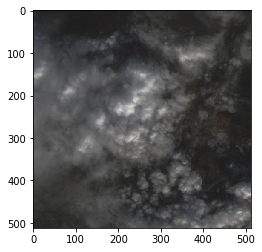

resized image 129 of size (256, 256)


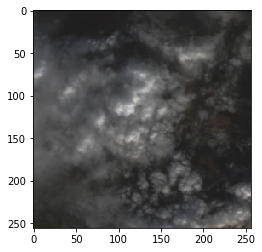

original gt 129 of size (512, 512)


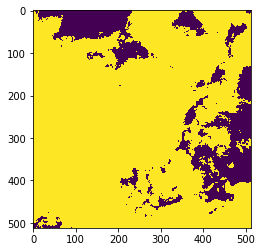

In [18]:
# # Visualize images

# rgb = Image.merge("RGB",(red,green,blue))
# print('original image ' + str(ind) + ' of size ' + str(rgb.size))
# plt.imshow(rgb)
# plt.show()
# img_r = np.asarray(rgb) 
# img_r = resize(img_r, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True).astype('uint8')
# img_r_img = Image.fromarray(img_r, 'RGB') # own idea to realize an image plot
# print('resized image ' + str(ind) + ' of size ' + str(img_r_img.size))
# plt.imshow(img_r_img)
# plt.show()      

# gt = Image.open(GT_PATH + str(ind) + '.png')
# print('original gt ' + str(ind) + ' of size ' + str(gt.size))
# plt.imshow(gt)
# plt.show()
# gt_r = np.array(gt)[:,:,1] 
# gt_r = resize(gt_r, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True).astype('uint8')
# gt_r_img = Image.fromarray(gt_r, 'L') # own idea to realize an image plot

In [20]:
# train images
for n, id_ in tqdm(enumerate(tr),total=350):
    red    = Image.open(TRAIN_PATH_R + str(int(id_)) + '.png').convert('L')
    green  = Image.open(TRAIN_PATH_G + str(int(id_)) + '.png').convert('L')
    blue   = Image.open(TRAIN_PATH_B + str(int(id_)) + '.png').convert('L')

    rgb = Image.merge("RGB",(red,green,blue))
    img_b = np.asarray(rgb) 

    #img_r = imread(TRAIN_PATH_R + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
    #img_g = imread(TRAIN_PATH_G + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
    #img_b = imread(TRAIN_PATH_B + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]

    #img_r = resize(img_r, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    #img_g = resize(img_g, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    #img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)

    img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
    img_b= (img_b/255.0)
    #for i in range(256):
    #       img[i] = np.concatenate((img_r[i],img_g[i],img_b[i]), axis=1)

    X_train[n] = img_b.astype(np.float32)

    #mask = Image.open('/content/drive/My Drive/Colab Notebooks/dataset/BQA/train/' + str(int(102+id_)) + '.png').convert('L')
    mask = imread(path_data + 'BQA/train/' + str(int(id_)) + '.png')[:,:,1]
    mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH), order=0, mode='constant', preserve_range=True, anti_aliasing=False)
    #mask1 = np.asarray(mask)
    #mask1 = resize(mask1, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
 
    Y_train[n] = (mask1==1).astype(int)


100%|██████████| 350/350 [00:40<00:00,  8.63it/s]


In [41]:
#test images
nr_images = 36

te=np.zeros(nr_images)
for i in range(nr_images):
    te[i]=i;

# for test images 
X_test = np.zeros((nr_images, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((nr_images, IMG_WIDTH, IMG_WIDTH, 1), dtype=np.float32)
img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_test = []
 
for n, id_ in tqdm(enumerate(te),total=nr_images):
    if int(id_) <= 9:
        red    = Image.open(TEST_PATH_R + str(170+int(id_)) + '.png').convert('L')
        green  = Image.open(TEST_PATH_G + str(170+int(id_)) + '.png').convert('L')
        blue   = Image.open(TEST_PATH_B + str(170+int(id_)) + '.png').convert('L')
         
        rgb = Image.merge("RGB",(red,green,blue))
        img_b = np.asarray(rgb)  
        img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
        img_b=img_b/255.0

        X_test[n] = img_b

        mask = imread(path_data+ 'BQA/test/' + str(int(170+id_)) + '.png')[:,:,:IMG_CHANNELS]
        mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
        
    else:
        red    = Image.open(TEST_PATH_R + str(314+int(id_)) + '.png').convert('L')
        green  = Image.open(TEST_PATH_G + str(314+int(id_)) + '.png').convert('L')
        blue   = Image.open(TEST_PATH_B + str(314+int(id_)) + '.png').convert('L')

        rgb = Image.merge("RGB",(red,green,blue))
        img_b = np.asarray(rgb)  
        img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
        img_b=img_b/255.0

        X_test[n] = img_b

        mask = imread(path_data+ 'BQA/test/' + str(int(314+id_)) + '.png')[:,:,:IMG_CHANNELS]
        mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)

    Y_test[n] = (mask1/255.0>0.3).astype(int)
    


100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


In [46]:
model = model_arch(input_rows=256, input_cols=256, num_of_channels=3, num_of_classes=1)
model.compile(optimizer = Adam(lr = 1e-4), loss = jacc_coef, metrics = [jacc_coef,'accuracy'])


In [ ]:
results = model.fit(X_train, Y_train, validation_split=0.05, batch_size=16, epochs=10, verbose=1)

Train on 332 samples, validate on 18 samples
Epoch 1/10


In [47]:
# Save the entire model 
model.save(path_model) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/Willem/Werk/510/caladrius/clouds_Nina/saved_models/0113v0_model/assets


In [ ]:
results.history

In [ ]:
# with open('/Users/Willem/Werk/510/caladrius/clouds_Nina/saved_models/_model/results.pkl', 'wb') as f:
#     pickle.dump(results.history, f)

## Evaluating model

In [52]:
def mean_iou(gt, mask):
    gt = gt.flatten()
    mask = mask.flatten()
    tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
    iou = tp/(tp+fn+fp)
    iou_n = tn/(tn+fn+fp)
    rec = 0.5 * iou + 0.5 * iou_n
    return(rec)

def fw_iou(gt, mask):
    gt = gt.flatten()
    mask = mask.flatten()
    tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
    iou = tp/(tp+fn+fp)
    iou_n = tn/(tn+fn+fp)
    cloud_weight = (tp + fp)/(tn + fp + fn + tp)
    rec = cloud_weight * iou + (1 - cloud_weight) * iou_n
    return(rec)

sum = 0
for i in range(len(Y_test)):
  #print('Jaccard Index ' + str(i) + ' ' + str(jaccard(Y_test[i],preds_test_t[i])))
  sum = sum + mean_iou(Y_test[i],test_pred[i])
mIoU = sum/len(Y_test)

sum = 0
for i in range(len(Y_test)):
  #print('Jaccard Index ' + str(i) + ' ' + str(jaccard(Y_test[i],preds_test_t[i])))
  sum = sum + fw_iou(Y_test[i],test_pred[i])
fwIoU = sum/len(Y_test)

print('Mean IoU: ' + str(mIoU))
print('Frequency weighted IoU: ' + str(fwIoU))


Mean IoU: 0.3943367004394531
Frequency weighted IoU: 0.7886688516940922


In [24]:
# Load model

test_model = tf.keras.models.load_model(path_model, compile=False)
test_model.compile(optimizer = Adam(lr = 1e-4), loss = jacc_coef, metrics = [jacc_coef,'accuracy'])


# test_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


ValueError: You tried to call `count_params` on input_4, but the layer isn't built. You can build it manually via: `input_4.build(batch_input_shape)`.

In [47]:
preds_test = test_model.predict(X_test, verbose=1)
test_pred = (preds_test > 0.5).astype(int)


10/1 [============================================================================================================================================================================================================================================================================================================] - 22s 2s/sample


KeyboardInterrupt: 

In [48]:
preds_test = model.predict(X_test, verbose=1)
test_pred = (preds_test > 0.5).astype(int)

10/1 [============================================================================================================================================================================================================================================================================================================] - 24s 2s/sample


In [53]:
from sklearn.metrics import confusion_matrix

def precision(gt,mask):
    gt = gt.flatten()
    mask = mask.flatten()
    tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
    prec = tp/(tp+fp)
    return(prec)

####recall---
def recall(gt,mask):
    gt = gt.flatten()
    mask = mask.flatten()
    tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
    rec = tp/(tp+fn)
    return(rec)

###f1 score--

def f1_score(prec,rec):
    f1 = 2*(prec*rec)/(prec+rec)
    return f1

  ### jaccard 
def jaccard(gt,mask):
    gt = gt.flatten()
    mask = mask.flatten()
    tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
    rec = tp/(tp+fn+fp)
    return(rec)

  ### jaccard 
def Overall(gt,mask):
    gt = gt.flatten()
    mask = mask.flatten()
    tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
    rec = (tp+tn)/(tp+fp+fn+tn)
    return(rec)

###aji score

def get_fast_aji(true, pred):
    
    true = np.copy(true) # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [None,]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)
    
    pred_masks = [None,]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)
    
    # prefill with value
    pairwise_inter = np.zeros([len(true_id_list) -1, 
                               len(pred_id_list) -1], dtype=np.float64)
    pairwise_union = np.zeros([len(true_id_list) -1, 
                               len(pred_id_list) -1], dtype=np.float64)

    # caching pairwise
    for true_id in true_id_list[1:]: # 0-th is background
        t_mask = true_masks[int(true_id)]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0: # ignore
                continue # overlaping background
            p_mask = pred_masks[int(pred_id)]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[int(true_id)-1, int(pred_id)-1] = inter
            pairwise_union[int(true_id)-1, int(pred_id)-1] = total - inter
    #
    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care 
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()
    #
    paired_true = (list(paired_true + 1)) # index to instance ID
    paired_pred = (list(paired_pred + 1))
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array([idx for idx in true_id_list[1:] if idx not in paired_true])
    unpaired_pred = np.array([idx for idx in pred_id_list[1:] if idx not in paired_pred])
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()
    #
    aji_score = overall_inter / overall_union
    return aji_score

sum_prec = 0
sum_rec = 0
sum_jac = 0
sum_over = 0
for i in range(len(Y_test)):
    print(i)
    sum_prec = sum_prec + precision(Y_test[i],test_pred[i])
    sum_rec = sum_rec + recall(Y_test[i],test_pred[i])
    sum_jac = sum_jac + jaccard(Y_test[i],test_pred[i])
    sum_over = sum_over + Overall(Y_test[i],test_pred[i])
prec = sum_prec/len(Y_test)
rec = sum_rec/len(Y_test)
jaccard1 = sum_jac/len(Y_test)
Overall1 = sum_over/len(Y_test)


f1 = f1_score(prec,rec)
aji = get_fast_aji(Y_test,test_pred)

print("Jaccard Index", jaccard1)
print("final f1", f1)
print("final precision",prec)
print("final recall",rec)
print("Overall Accuracy",Overall1)
print("final aji",aji)

0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


1


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


2


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


3


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


4


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


5


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


6


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


7


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


8
9
Jaccard Index 0.0
final f1 nan
final precision nan
final recall 0.0
Overall Accuracy 0.7886734008789062
final aji 0.7365967365967366
